In [1]:
#import modules needed to construct dataset
import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

import requests

download_files = False
#NOTE: the teddy files needed their headers edited to be read by pandas here

Note: It was necessary to edit the text files headers to enable them to be read by pandas this way. There may be another solution.

In [2]:
#download files if needed
teddy_path = "/home/richard/work_placement/spec_z_data/teddy/"
happy_path = "/home/richard/work_placement/spec_z_data/happy/"

url_teddy_A = "https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_A"
url_teddy_B = "https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_B"
url_teddy_C = "https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_C"
url_teddy_D = "https://github.com/COINtoolbox/photoz_catalogues/raw/master/Teddy/teddy_D"

url_happy_A = "https://github.com/COINtoolbox/photoz_catalogues/raw/master/Happy/happy_A"
url_happy_B = "https://github.com/COINtoolbox/photoz_catalogues/raw/master/Happy/happy_B"
url_happy_C = "https://github.com/COINtoolbox/photoz_catalogues/raw/master/Happy/happy_C"
url_happy_D = "https://github.com/COINtoolbox/photoz_catalogues/raw/master/Happy/happy_D"


if download_files == True:

    with open(teddy_path+"teddy_A.txt" , 'wb') as file:
        file.write(requests.get(url_teddy_A).content)
        file.close()

    with open(teddy_path+"teddy_B.txt" , 'wb') as file:
        file.write(requests.get(url_teddy_B).content)
        file.close()

    with open(teddy_path+"teddy_C.txt" , 'wb') as file:
        file.write(requests.get(url_teddy_C).content)
        file.close()

    with open(teddy_path+"teddy_D.txt" , 'wb') as file:
        file.write(requests.get(url_teddy_D).content)
        file.close()

    with open(happy_path+"happy_A.txt" , 'wb') as file:
        file.write(requests.get(url_happy_A).content)
        file.close()

    with open(happy_path+"happy_B.txt" , 'wb') as file:
        file.write(requests.get(url_happy_B).content)
        file.close()

    with open(happy_path+"happy_C.txt" , 'wb') as file:
        file.write(requests.get(url_happy_C).content)
        file.close()

    with open(happy_path+"happy_D.txt" , 'wb') as file:
        file.write(requests.get(url_happy_D).content)
        file.close()

else:
    print("Files Not Downloaded.")

Files Not Downloaded.


In [3]:
#read in the downloads
teddy_A = pd.read_table(teddy_path+"teddy_A.txt", delim_whitespace=True, header=6)
teddy_B = pd.read_table(teddy_path+"teddy_B.txt", delim_whitespace=True, header=6)
teddy_C = pd.read_table(teddy_path+"teddy_C.txt", delim_whitespace=True, header=6)
teddy_D = pd.read_table(teddy_path+"teddy_D.txt", delim_whitespace=True, header=6)

The Teddy Dataset initially contains SDSS detections (just the object ID, no ra or dec) with all some filters and colour values and the same features normalised.

We want to train our ML model on many filters but mainly PanSTARRS and 2MASS. To do this there are some steps required.

1) Cross-match the SDSS ObjIDs on CasJobs to get their Ra and Dec.
2) Using the Ra and Dec, cross-match by using fGetNearestObj Function in the PanSTARRS CasJobs with search radius 0.036 arcminutes. This allows us to get all PanSTARRS Filters too.
3) Using the same method, repeat cross-match for 2MASS. The fGetNearbyObj function must be used here as the PS1 Casjobs 2MASS DB does not have the nearest obj function.

There are some additional concerns with the data cross-matching, mainly:
- Duplicate detections of same ObjIDs returned in step 1. This can be avoided by removing duplicates based on ObjID.
- Duplicate cross-match detections from step 2 & 3. Though the fGetNearestObj documentation returns to return only the closest match, more matches can return than were searched for. Reason unknown to my knowledge and requires further inverstigation. Possibly can be solved by just taking the closer detection if the ObjIDS do not match. Else remove duplicates based on ObjIDs.

In [4]:
#add the ABCD datasets together and export to CSV for crossmatching externally in SDSS CasJobs
teddy_All = pd.concat([teddy_A, teddy_B, teddy_C, teddy_D]).reset_index(drop=True)

In [5]:
len(teddy_All)

322770

In [6]:
teddy_A

,id,mag_r,u-g,g-r,r-i,i-z,z_spec,feat1,feat2,feat3,feat4,feat5
0,1237645942905110768,18.914286,2.072901,1.386738,0.482288,0.272480,0.309728,-0.001069,0.205242,0.123685,-0.623802,-0.354959
1,1237645942905569773,19.394960,1.544794,1.557312,0.541681,0.418470,0.336479,0.283997,-0.262650,0.449938,-0.441687,0.242252
2,1237645943978328381,19.886253,1.028398,1.764324,0.672249,0.374681,0.406500,0.575361,-0.720166,0.845885,-0.041332,0.063122
3,1237645943978524819,17.561859,2.166397,1.304127,0.428728,0.303825,0.192485,-0.803132,0.288078,-0.034323,-0.788032,-0.226733
4,1237645943978524889,18.495819,1.359457,1.720991,0.521324,0.360054,0.319904,-0.249242,-0.426855,0.763003,-0.504107,0.003285
...,...,...,...,...,...,...,...,...,...,...,...,...
74304,1237680531354026438,17.905106,1.300573,1.518801,0.522589,0.404392,0.261464,-0.599567,-0.479025,0.376278,-0.500230,0.184661
74305,1237680531354878404,17.588964,1.442886,1.408772,0.542276,0.394083,0.223003,-0.787057,-0.352938,0.165828,-0.439862,0.142489
74306,1237680531355009174,20.376284,1.748831,1.362972,0.759176,0.427336,0.478527,0.865976,-0.081877,0.078229,0.225210,0.278518
74307,1237680531355795869,18.126299,1.480217,1.483189,0.573711,0.359980,0.274434,-0.468388,-0.319864,0.308164,-0.343474,0.002980


<Axes: xlabel='z_spec', ylabel='Count'>

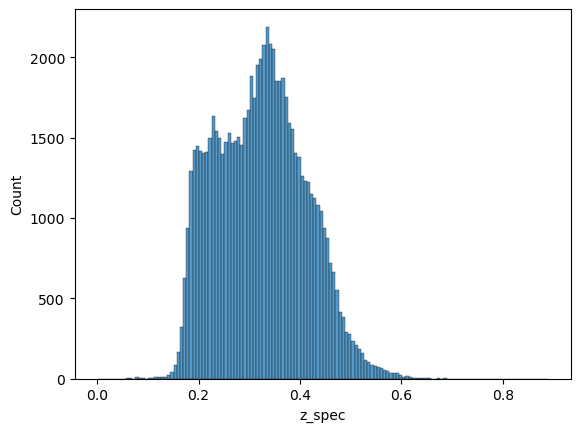

In [51]:
sns.histplot(teddy_B.z_spec)

<Axes: xlabel='mag_r', ylabel='Count'>

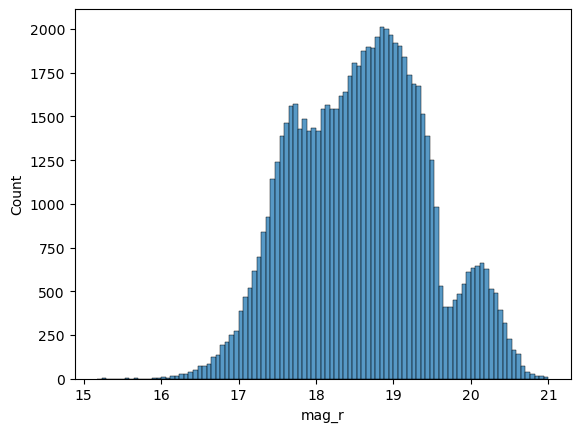

In [7]:
sns.histplot(teddy_A.mag_r)

<Axes: xlabel='feat1', ylabel='Count'>

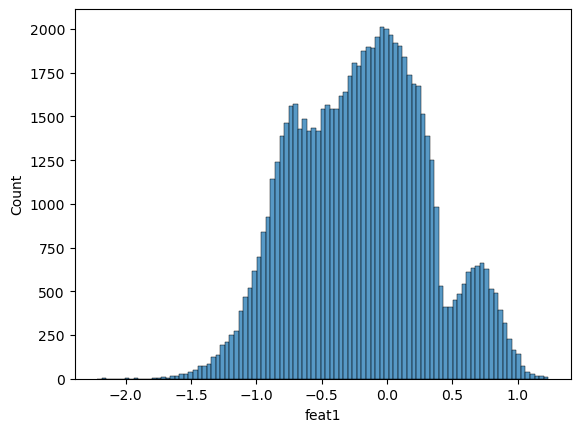

In [8]:
sns.histplot(teddy_A.feat1)

In [9]:
#the normalised features are not needed right now, and can drop colour data
teddy_All = teddy_All.loc[:, ["id","z_spec"]]

In [10]:
#save as csv, then can be used to get sdss ra and dec
teddy_All.to_csv("spec_id_list.csv", header = ["SDSSid","zSpec",], index=False)

In [11]:
# this was ran on the SDSS casjobs under context DR12
"""
select ObjID as SDSSID, ra as SDSSRa, dec as SDSSDec, z, zErr,
  modelMag_u as SDSS_uMag, modelMag_g as SDSS_gMag, modelMag_r as SDSS_rMag, modelMag_i as SDSS_iMag, modelMag_z as SDSS_zMag
  modelMagErr_u as SDSS_uMagErr, modelMagErr_g as SDSS_gMagErr, modelMagErr_r as SDSS_rMagErr, modelMagErr_i as SDSS_iMagErr, modelMagErr_z as SDSS_zMagErr
into mydb.teddyAll from dr12.SpecPhotoAll 
where ObjId in (select SDSSid from mydb.specObjId)
"""

'\nselect ObjID as SDSSID, ra as SDSSRa, dec as SDSSDec, z, zErr,\n  modelMag_u as SDSS_uMag, modelMag_g as SDSS_gMag, modelMag_r as SDSS_rMag, modelMag_i as SDSS_iMag, modelMag_z as SDSS_zMag\n  modelMagErr_u as SDSS_uMagErr, modelMagErr_g as SDSS_gMagErr, modelMagErr_r as SDSS_rMagErr, modelMagErr_i as SDSS_iMagErr, modelMagErr_z as SDSS_zMagErr\ninto mydb.teddyAll from dr12.SpecPhotoAll \nwhere ObjId in (select SDSSid from mydb.specObjId)\n'

In [12]:
#the table was then downloaded from sdss casjobs and uploaded to PS1 casjobs.
#this query was run under the ps1 data release 2 context
"""
SELECT
    t.SDSSID, t.SDSSRa, t.SDSSDec, t.z, t.ZErr, t.SDSS_uMag, t.SDSS_gMag, t.SDSS_rMag, t.SDSS_iMag, t.SDSS_zMag, t.SDSS_uMagErr, t.SDSS_gMagErr, t.SDSS_rMagErr, t.SDSS_iMagErr, t.SDSS_zMagErr,
    n.objID as PS1ID, n.distance AS PS1AngSep,
    o.raStack as PS1Ra, o.decStack as PS1Dec,
    s.gKronMag, s.rKronMag, s.iKronMag, s.zKronMag, s.yKronMag, s.gKronMagErr, s.rKronMagErr, s.iKronMagErr, s.zKronMagErr, s.yKronMagErr
FROM mydb.TeddyCustom as t
    CROSS APPLY fGetNearestObjEq( t.SDSSra, t.SDSSdec, 0.036) as n
    JOIN StackObjectThin as s ON n.objID=s.objID
    JOIN ObjectThin AS o ON n.objID=o.objID
INTO TeddyCustom_PS1
"""

'\nSELECT\n    t.SDSSID, t.SDSSRa, t.SDSSDec, t.z, t.ZErr, t.SDSS_uMag, t.SDSS_gMag, t.SDSS_rMag, t.SDSS_iMag, t.SDSS_zMag, t.SDSS_uMagErr, t.SDSS_gMagErr, t.SDSS_rMagErr, t.SDSS_iMagErr, t.SDSS_zMagErr,\n    n.objID as PS1ID, n.distance AS PS1AngSep,\n    o.raStack as PS1Ra, o.decStack as PS1Dec,\n    s.gKronMag, s.rKronMag, s.iKronMag, s.zKronMag, s.yKronMag, s.gKronMagErr, s.rKronMagErr, s.iKronMagErr, s.zKronMagErr, s.yKronMagErr\nFROM mydb.TeddyCustom as t\n    CROSS APPLY fGetNearestObjEq( t.SDSSra, t.SDSSdec, 0.036) as n\n    JOIN StackObjectThin as s ON n.objID=s.objID\n    JOIN ObjectThin AS o ON n.objID=o.objID\nINTO TeddyCustom_PS1\n'

In [13]:
#this query was also ran in the ps1 casjobs under the TwoMassNew context
#for psc
"""
SELECT
    t.SDSSID, t.SDSSRa, t.SDSSDec, t.z, t.ZErr, t.SDSS_uMag, t.SDSS_gMag, t.SDSS_rMag, t.SDSS_iMag, t.SDSS_zMag, t.SDSS_uMagErr, t.SDSS_gMagErr, t.SDSS_rMagErr, t.SDSS_iMagErr, t.SDSS_zMagErr,
    t.PS1ID, t.PS1AngSep, t.PS1Ra, t.PS1Dec, t.gKronMag, t.rKronMag, t.iKronMag, t.zKronMag, t.yKronMag, t.gKronMagErr, t.rKronMagErr, t.iKronMagErr, t.zKronMagErr, t.yKronMagErr,
    n.objID as TMassID, n.distance as TMassAngSep,
    p.ra as TMassRa, p.decl as TMassDec, p.j_m, p.h_m, p.k_m, p.j_msigcom as j_err, p.h_msigcom as h_err, p.k_msigcom as k_err
FROM mydb.TeddyCustom_PS1 as t
    CROSS APPLY fGetNearbyObjEq( t.SDSSra, t.SDSSdec, 0.036) as n
    JOIN twomass_psc as p ON n.objID=p.objID
INTO TeddyCustom_PS1_2MASS_PSC
"""

#for xsc
"""
SELECT
    t.SDSSID, t.SDSSRa, t.SDSSDec, t.z, t.ZErr, t.SDSS_uMag, t.SDSS_gMag, t.SDSS_rMag, t.SDSS_iMag, t.SDSS_zMag, t.SDSS_uMagErr, t.SDSS_gMagErr, t.SDSS_rMagErr, t.SDSS_iMagErr, t.SDSS_zMagErr,
    t.PS1ID, t.PS1AngSep, t.PS1Ra, t.PS1Dec, t.gKronMag, t.rKronMag, t.iKronMag, t.zKronMag, t.yKronMag, t.gKronMagErr, t.rKronMagErr, t.iKronMagErr, t.zKronMagErr, t.yKronMagErr,
    n.objID as TMassID, n.distance as TMassAngSep,
    x.ra as TMassXRa, x.decl as TMassXDec, x.j_m_k20fe as j_fm, x.h_m_k20fe as h_fm, x.k_m_k20fe as k_fm, x.j_msig_k20fe as j_fmErr, x.h_msig_k20fe as h_fmErr, x.k_msig_k20fe as k_fmErr
FROM mydb.TeddyCustom_PS1 as t
    CROSS APPLY fGetNearbyObjEq( t.SDSSra, t.SDSSdec, 0.036) as n
    JOIN twomass_xsc as x ON n.objID=x.objID
INTO TeddyCustom_PS1_2MASS_XSC
"""
#had to use 2 diff queries because no catalog I could find contained all 2mass xsc+psc

'\nSELECT\n    t.SDSSID, t.SDSSRa, t.SDSSDec, t.z, t.ZErr, t.SDSS_uMag, t.SDSS_gMag, t.SDSS_rMag, t.SDSS_iMag, t.SDSS_zMag, t.SDSS_uMagErr, t.SDSS_gMagErr, t.SDSS_rMagErr, t.SDSS_iMagErr, t.SDSS_zMagErr,\n    t.PS1ID, t.PS1AngSep, t.PS1Ra, t.PS1Dec, t.gKronMag, t.rKronMag, t.iKronMag, t.zKronMag, t.yKronMag, t.gKronMagErr, t.rKronMagErr, t.iKronMagErr, t.zKronMagErr, t.yKronMagErr,\n    n.objID as TMassID, n.distance as TMassAngSep,\n    x.ra as TMassXRa, x.decl as TMassXDec, x.j_m_k20fe as j_fm, x.h_m_k20fe as h_fm, x.k_m_k20fe as k_fm, x.j_msig_k20fe as j_fmErr, x.h_msig_k20fe as h_fmErr, x.k_msig_k20fe as k_fmErr\nFROM mydb.TeddyCustom_PS1 as t\n    CROSS APPLY fGetNearbyObjEq( t.SDSSra, t.SDSSdec, 0.036) as n\n    JOIN twomass_xsc as x ON n.objID=x.objID\nINTO TeddyCustom_PS1_2MASS_XSC\n'

In [14]:
#loading the datasets from the above queries
TeddyCustom_PS1 = pd.read_csv("/home/richard/work_placement/spec_z_data/master_Teddy/TeddyCustom_PS1_richardon.csv")
TeddyCustom_2MassXSC = pd.read_csv("/home/richard/work_placement/spec_z_data/master_Teddy/TeddyCustom_PS1_2MASS_XSC_richardon.csv")
TeddyCustom_2MassPSC = pd.read_csv("/home/richard/work_placement/spec_z_data/master_Teddy/TeddyCustom_PS1_2MASS_PSC_richardon.csv")

In [15]:
#only need the 2mass columns
TeddyCustom_2MassPSC = TeddyCustom_2MassPSC[["SDSSID","TMassID","TMassAngSep","TMassRa","TMassDec",
                                             "j_m","h_m","k_m","j_err","h_err","k_err"]]

In [16]:
#renaming so can append to the psc, both errors in xsc and psc are 1 sigma
TeddyCustom_2MassXSC = TeddyCustom_2MassXSC[["SDSSID","TMassID","TMassAngSep","TMassXRa","TMassXDec",
                                             "j_fm","h_fm","k_fm","j_fmErr","h_fmErr","k_fmErr"]].rename(
    columns={"j_fm":"j_m","h_fm":"h_m","k_fm":"k_m","j_fmErr":"j_err","h_fmErr":"h_err","k_fmErr":"k_err",
            "TMassXRa":"TMassRa", "TMassXDec":"TMassDec"})

In [17]:
TeddyCustom_2MassPSC["PSC"] = np.ones(len(TeddyCustom_2MassPSC))
TeddyCustom_2MassXSC["XSC"] = np.ones(len(TeddyCustom_2MassXSC))

In [18]:
#2mass all sources
TeddyCustom_2Mass = pd.concat([TeddyCustom_2MassPSC, TeddyCustom_2MassXSC])
TeddyCustom_2Mass["PSC"] = TeddyCustom_2Mass["PSC"].fillna(0).astype("Int64")
TeddyCustom_2Mass["XSC"] = TeddyCustom_2Mass["XSC"].fillna(0).astype("Int64")

In [19]:
TeddyCustom_2Mass

,SDSSID,TMassID,TMassAngSep,TMassRa,TMassDec,j_m,h_m,k_m,j_err,h_err,k_err,PSC,XSC
0,1237652942092370320,64324465,0.006934,338.405665,12.602542,16.750,15.564,15.099,0.161,0.112,0.179,1,0
1,1237652942092370320,64324465,0.006934,338.405665,12.602542,16.750,15.564,15.099,0.161,0.112,0.179,1,0
2,1237656241162813936,64324840,0.010523,338.320879,12.830689,16.525,15.866,14.796,0.136,0.143,NaN,1,0
3,1237656241162813936,64324840,0.010523,338.320879,12.830689,16.525,15.866,14.796,0.136,0.143,NaN,1,0
4,1237656241162813936,64324840,0.010523,338.320879,12.830689,16.525,15.866,14.796,0.136,0.143,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629,1237680530819121362,3000607687,0.003594,356.780518,30.420893,15.624,NaN,14.178,0.153,NaN,0.160,0,1
61630,1237680531353633290,3000556028,0.005421,350.465302,30.356781,15.821,NaN,14.368,0.145,NaN,0.189,0,1
61631,1237680531353633290,3000556028,0.005421,350.465302,30.356781,15.821,NaN,14.368,0.145,NaN,0.189,0,1
61632,1237680531354878300,3000666291,0.009156,353.714935,30.661831,15.500,14.819,14.203,0.118,0.152,0.165,0,1


In [20]:
print("PS1 XMatch Duplicate Values\n",TeddyCustom_PS1.duplicated(subset="PS1ID", keep="first").value_counts(),"\n")
print("PS1 XMatch Duplicate Values (SDSSID Matches)\n",TeddyCustom_PS1.duplicated(subset="SDSSID", keep="first").value_counts(),"\n")

print("2MASS XMatch Duplicate Values\n",TeddyCustom_2Mass.duplicated(subset="TMassID", keep="first").value_counts(),"\n")
print("2MASS XMatch Duplicate Values (SDSSID Matches)\n",TeddyCustom_2Mass.duplicated(subset="SDSSID", keep="first").value_counts(),"\n")

PS1 XMatch Duplicate Values
 False    314332
True      97455
dtype: int64 

PS1 XMatch Duplicate Values (SDSSID Matches)
 False    314325
True      97462
dtype: int64 

2MASS XMatch Duplicate Values
 False    210733
True      65356
dtype: int64 

2MASS XMatch Duplicate Values (SDSSID Matches)
 False    163472
True     112617
dtype: int64 



Dropping Duplicate Values

- Sort by Ang Sep for PS1 ascending.
- Drop Duplicates keeping the first instance.
- Left with lowest Ang Sep Matches

- Repeat for 2Mass Ang Sep

In [21]:
TeddyCustom_2Mass = TeddyCustom_2Mass.sort_values(by = "TMassAngSep", ascending=True,
                                                  kind="stable").drop_duplicates(
    subset="TMassID", keep="first", ignore_index=True)

In [22]:
TeddyCustom_PS1 = TeddyCustom_PS1.sort_values(by = "PS1AngSep", ascending=True,
                                                  kind="stable").drop_duplicates(
    subset="PS1ID", keep="first", ignore_index=True)

In [23]:
print(TeddyCustom_PS1.duplicated(subset="PS1ID", keep="first").value_counts())
print(TeddyCustom_2Mass.duplicated(subset="TMassID", keep="first").value_counts())

False    314332
dtype: int64
False    210733
dtype: int64


Got rid of duplicate values from each dataframe, now converting 2mass id to string so dtype does not change to float when Nans are introduced during join.

In [24]:
TeddyCustom_2Mass["TMassID"] = TeddyCustom_2Mass["TMassID"].astype(str)

In [25]:
#the join
TeddyCustom = TeddyCustom_PS1.set_index("SDSSID").join(
    TeddyCustom_2Mass.set_index("SDSSID"), how="outer").reset_index().drop_duplicates(
    subset="SDSSID", keep="first", ignore_index=True)

In [26]:
#changing back to int
TeddyCustom["TMassID"] = TeddyCustom["TMassID"].astype('Int64')

In [27]:
#re-arranging columns for aesthetics
TeddyCustom.columns

Index(['SDSSID', 'SDSSRa', 'SDSSDec', 'z', 'ZErr', 'SDSS_uMag', 'SDSS_gMag',
       'SDSS_rMag', 'SDSS_iMag', 'SDSS_zMag', 'SDSS_uMagErr', 'SDSS_gMagErr',
       'SDSS_rMagErr', 'SDSS_iMagErr', 'SDSS_zMagErr', 'PS1ID', 'PS1AngSep',
       'PS1Ra', 'PS1Dec', 'gKronMag', 'rKronMag', 'iKronMag', 'zKronMag',
       'yKronMag', 'gKronMagErr', 'rKronMagErr', 'iKronMagErr', 'zKronMagErr',
       'yKronMagErr', 'TMassID', 'TMassAngSep', 'TMassRa', 'TMassDec', 'j_m',
       'h_m', 'k_m', 'j_err', 'h_err', 'k_err', 'PSC', 'XSC'],
      dtype='object')

In [28]:
TeddyCustom = TeddyCustom[['SDSSID', 'SDSSRa', 'SDSSDec',
                           'PS1ID', 'PS1AngSep', 'PS1Ra', 'PS1Dec',
                           'TMassID', 'TMassAngSep', 'TMassRa', 'TMassDec',
                           'SDSS_uMag', 'SDSS_gMag', 'SDSS_rMag', 'SDSS_iMag', 'SDSS_zMag',
                           'SDSS_uMagErr', 'SDSS_gMagErr','SDSS_rMagErr', 'SDSS_iMagErr', 'SDSS_zMagErr',
                           'gKronMag', 'rKronMag', 'iKronMag', 'zKronMag','yKronMag',
                           'gKronMagErr', 'rKronMagErr', 'iKronMagErr', 'zKronMagErr','yKronMagErr',
                           'j_m', 'h_m', 'k_m', 'j_err', 'h_err', 'k_err',
                           'z', 'ZErr']]

In [29]:
#converting from Vega to A/B Mags
TeddyCustom["j_m"] = TeddyCustom["j_m"]+0.91
TeddyCustom["h_m"] = TeddyCustom["h_m"]+1.39
TeddyCustom["k_m"] = TeddyCustom["k_m"]+1.85

In [30]:
TeddyCustom

,SDSSID,SDSSRa,SDSSDec,PS1ID,PS1AngSep,PS1Ra,PS1Dec,TMassID,TMassAngSep,TMassRa,...,zKronMagErr,yKronMagErr,j_m,h_m,k_m,j_err,h_err,k_err,z,ZErr
0,1237645879577739681,49.873779,1.271194,109520498737885992,0.002551,49.873782,1.271280,<NA>,NaN,NaN,...,0.022784,0.040340,NaN,NaN,NaN,NaN,NaN,NaN,0.293778,0.000078
1,1237645942904520927,54.936769,0.216784,108260549367510630,0.001892,54.936760,0.216837,853887236,0.004722,54.936696,...,0.007639,0.009580,17.091999,16.963000,16.263,0.160,0.159,0.114,0.201237,0.000050
2,1237645942904914122,55.717067,0.217682,108260557170261667,0.001987,55.717017,0.217711,783976529,0.003779,55.717017,...,0.010557,0.018087,17.510000,17.331000,17.075,0.157,0.173,0.185,0.299481,0.000050
3,1237645942905110768,56.243814,0.216326,108260562437900045,0.001342,56.243769,0.216336,<NA>,NaN,NaN,...,0.012939,0.021645,NaN,NaN,NaN,NaN,NaN,NaN,0.309728,0.000043
4,1237645942905504072,57.075470,0.038348,108040570754586524,0.001540,57.075460,0.038408,1331736936,0.009250,57.075617,...,0.014055,0.022498,17.867001,17.394999,16.839,0.169,0.168,0.123,0.349115,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314320,1237680531356123560,357.042770,31.006018,145203570427277845,0.001431,357.042734,31.006044,<NA>,NaN,NaN,...,0.013019,0.025751,NaN,NaN,NaN,NaN,NaN,NaN,0.343875,0.000069
314321,1237680531356189084,357.218970,30.829394,144993572188965836,0.001041,357.218930,30.829394,741912533,0.000497,357.218961,...,0.011905,0.018745,17.580000,17.356000,17.304,0.141,0.179,0.198,0.282889,0.000045
314322,1237680531356189119,357.282550,30.873288,145043572825378512,0.000793,357.282533,30.873276,741912434,0.003289,357.282539,...,0.012138,0.015684,17.610001,17.385000,16.585,0.167,0.213,0.109,0.291777,0.000059
314323,1237680531356254710,357.307100,30.855049,145023573070966658,0.002335,357.307096,30.855070,741912478,0.000729,357.307094,...,0.008902,0.019618,17.556999,17.113000,16.686,0.191,0.155,0.131,0.296219,0.000047


In [31]:
TeddyCustom.query("gKronMag.isna()==True")

,SDSSID,SDSSRa,SDSSDec,PS1ID,PS1AngSep,PS1Ra,PS1Dec,TMassID,TMassAngSep,TMassRa,...,zKronMagErr,yKronMagErr,j_m,h_m,k_m,j_err,h_err,k_err,z,ZErr


In [32]:
#dealing with the ps1 nan values (rep as -999)
TeddyCustom = TeddyCustom.replace(-999, np.nan)

SDSSID               0
SDSSRa               0
SDSSDec              0
PS1ID                0
PS1AngSep            0
PS1Ra                1
PS1Dec               1
TMassID         150856
TMassAngSep     150856
TMassRa         150856
TMassDec        150856
SDSS_uMag            0
SDSS_gMag            0
SDSS_rMag            0
SDSS_iMag            0
SDSS_zMag            0
SDSS_uMagErr         0
SDSS_gMagErr         0
SDSS_rMagErr         0
SDSS_iMagErr         0
SDSS_zMagErr         0
gKronMag         12312
rKronMag          3523
iKronMag          3640
zKronMag          2945
yKronMag          3253
gKronMagErr      12262
rKronMagErr       3460
iKronMagErr       3586
zKronMagErr       2914
yKronMagErr       3242
j_m             151211
h_m             152443
k_m             150856
j_err           157574
h_err           162744
k_err           157316
z                    0
ZErr                 0
dtype: int64 




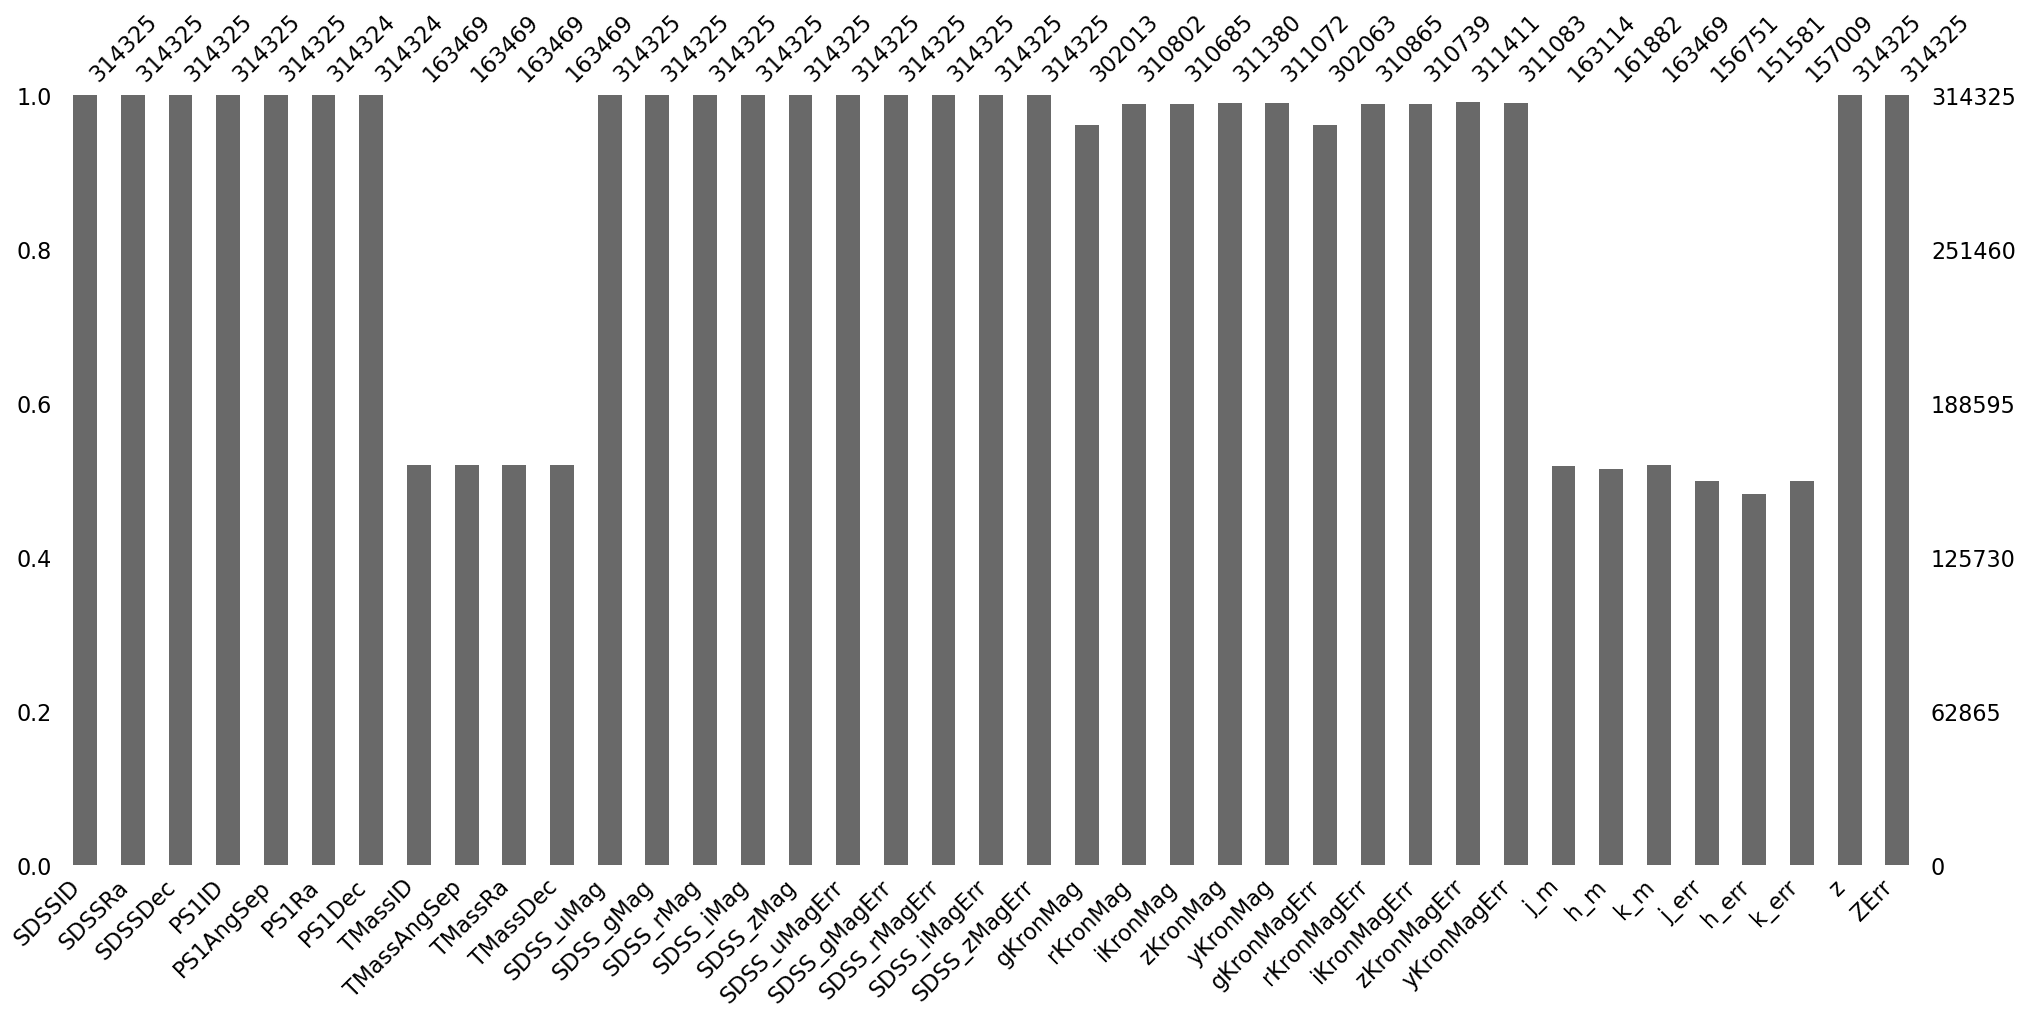

In [33]:
print(TeddyCustom.isna().sum(),"\n\n")
msno.bar(TeddyCustom)
plt.show()

In [34]:
TeddyCustom = TeddyCustom[TeddyCustom['PS1Ra'].notna()]
TeddyCustom = TeddyCustom[TeddyCustom['gKronMag'].notna()]
TeddyCustom = TeddyCustom[TeddyCustom['rKronMag'].notna()]
TeddyCustom = TeddyCustom[TeddyCustom['iKronMag'].notna()]
TeddyCustom = TeddyCustom[TeddyCustom['zKronMag'].notna()]
TeddyCustom = TeddyCustom[TeddyCustom['yKronMag'].notna()]
TeddyCustom = TeddyCustom[TeddyCustom['yKronMagErr'].notna()]

SDSSID               0
SDSSRa               0
SDSSDec              0
PS1ID                0
PS1AngSep            0
PS1Ra                0
PS1Dec               0
TMassID         135963
TMassAngSep     135963
TMassRa         135963
TMassDec        135963
SDSS_uMag            0
SDSS_gMag            0
SDSS_rMag            0
SDSS_iMag            0
SDSS_zMag            0
SDSS_uMagErr         0
SDSS_gMagErr         0
SDSS_rMagErr         0
SDSS_iMagErr         0
SDSS_zMagErr         0
gKronMag             0
rKronMag             0
iKronMag             0
zKronMag             0
yKronMag             0
gKronMagErr          0
rKronMagErr          0
iKronMagErr          0
zKronMagErr          0
yKronMagErr          0
j_m             136310
h_m             137529
k_m             135963
j_err           142360
h_err           147418
k_err           142177
z                    0
ZErr                 0
dtype: int64 




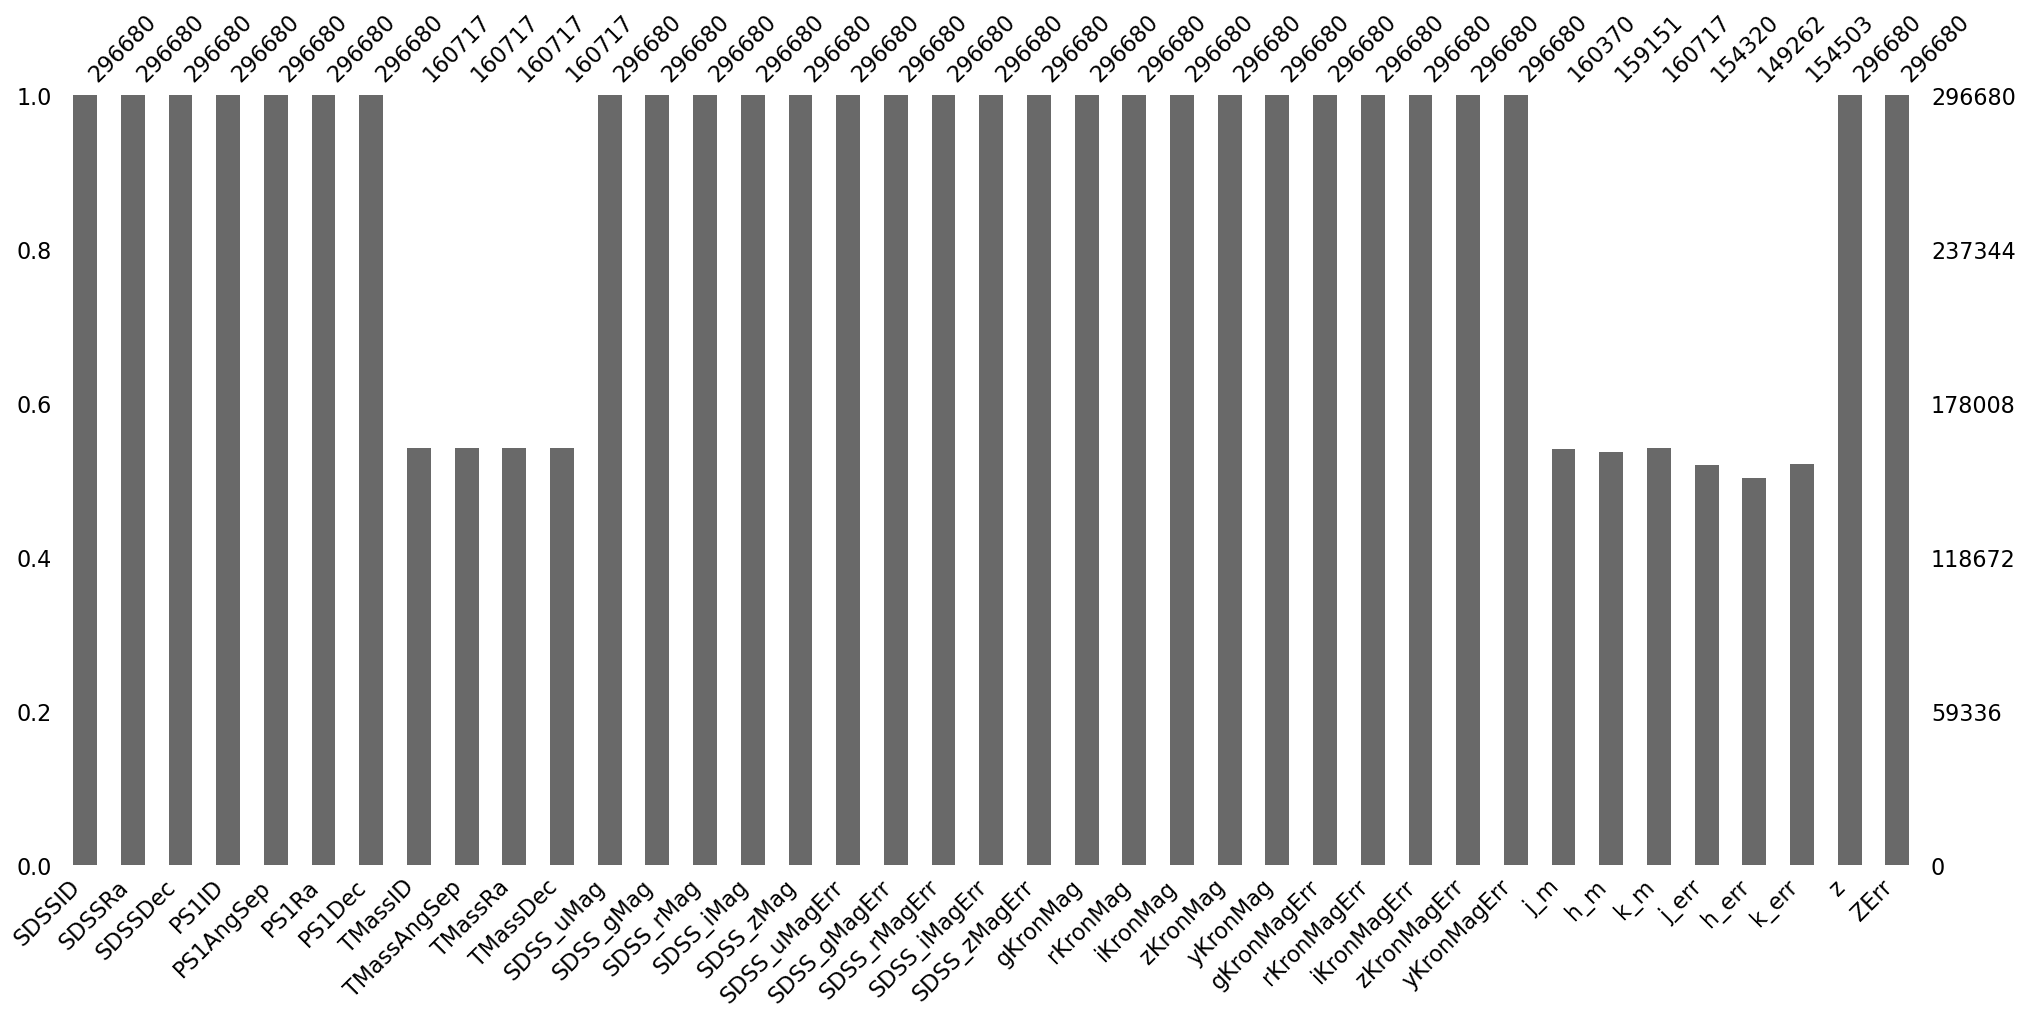

In [35]:
print(TeddyCustom.isna().sum(),"\n\n")
msno.bar(TeddyCustom)
plt.show()

In [36]:
#save as csv
TeddyCustom.to_csv("TeddyCustom.csv", index=False)

In [37]:
TeddyCustom_2Mass


,SDSSID,TMassID,TMassAngSep,TMassRa,TMassDec,j_m,h_m,k_m,j_err,h_err,k_err,PSC,XSC
0,1237661818170573045,156278351,0.000000,191.891010,13.349587,16.219,15.408,14.793,0.091,0.124,0.086,1,0
1,1237662193992859808,211970367,0.000000,194.749940,41.524513,16.107,15.268,14.689,0.085,0.090,0.081,1,0
2,1237674649928532220,222847502,0.000000,179.675290,-0.214184,15.301,14.681,13.987,0.092,0.108,0.085,1,0
3,1237651250412388483,502859048,0.000000,132.544720,51.775410,14.587,13.978,13.463,0.066,0.082,0.057,1,0
4,1237664132091084939,584345501,0.000000,159.318380,13.882783,15.779,14.983,14.465,0.097,0.102,0.096,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210728,1237663782599917843,3001495313,0.035893,30.057196,-1.204183,15.074,14.240,13.744,0.080,0.084,0.108,0,1
210729,1237654344938291477,621555353,0.035909,213.774546,63.078659,16.684,16.101,15.282,0.145,0.161,0.133,1,0
210730,1237664852031045897,176043247,0.035960,208.497891,34.172073,15.847,14.957,14.102,0.090,0.097,NaN,1,0
210731,1237651753483698252,3000259379,0.035977,203.446228,2.045501,14.300,13.731,13.409,0.077,0.089,0.131,0,1


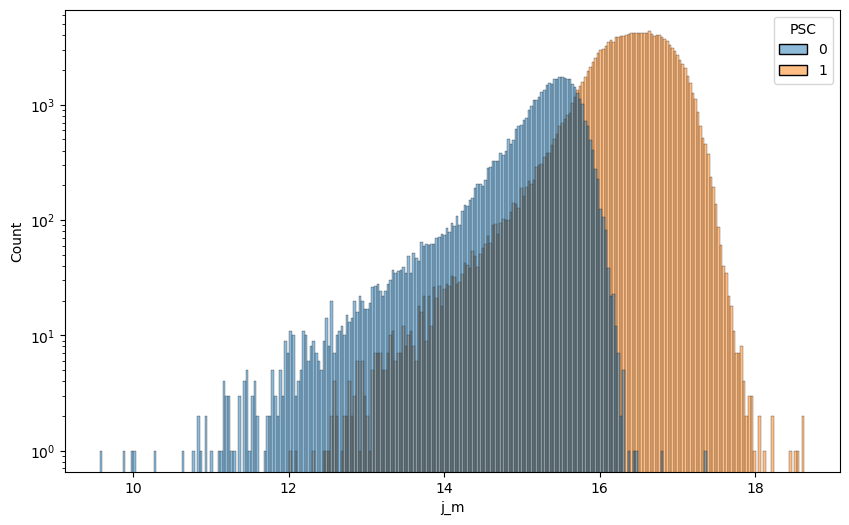

In [38]:
fig, axs = plt.subplots(1, figsize=(10,6))
sns.histplot(
    data=TeddyCustom_2Mass,
    x="j_m",
    hue="PSC",
    multiple="layer")

plt.yscale('log')
plt.show()

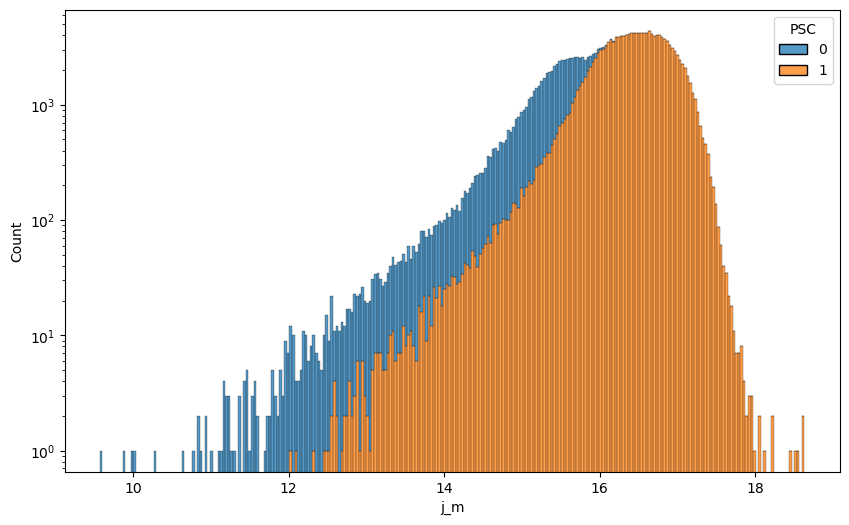

In [39]:
fig, axs = plt.subplots(1, figsize=(10,6))
sns.histplot(
    data=TeddyCustom_2Mass,
    x="j_m",
    hue="PSC",
    multiple="stack")

plt.yscale('log')
plt.show()

<Axes: xlabel='TMassAngSep', ylabel='Count'>

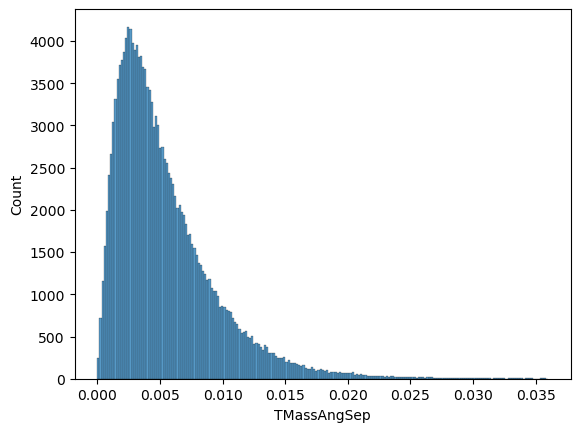

In [40]:
sns.histplot(TeddyCustom.TMassAngSep)

In [41]:
TeddyCustom.query("j_err < 0.05")

,SDSSID,SDSSRa,SDSSDec,PS1ID,PS1AngSep,PS1Ra,PS1Dec,TMassID,TMassAngSep,TMassRa,...,zKronMagErr,yKronMagErr,j_m,h_m,k_m,j_err,h_err,k_err,z,ZErr
101,1237646645693186144,86.492678,-1.048012,106740864926742834,0.000969,86.492673,-1.047995,147320262,0.000713,86.492667,...,0.001789,0.003262,15.326,15.110,15.208,0.032,0.035,0.041,0.915344,0.000026
935,1237648704054231121,215.422080,-0.366028,107562154220811318,0.001842,215.422090,-0.365947,3001034567,0.001972,215.422058,...,0.001609,0.003742,14.963,14.692,14.858,0.049,0.055,0.070,0.051992,0.000012
5735,1237649954406727800,27.173589,14.171078,125000271736205811,0.000249,27.173618,14.171092,340174779,0.001130,27.173602,...,0.002195,0.004032,15.788,15.551,15.688,0.045,0.053,0.056,0.064153,0.000008
6793,1237650370487910530,193.621280,-2.607185,104871936212551795,0.001222,193.621272,-2.607170,3001405605,0.000267,193.621277,...,0.002442,0.003435,14.683,14.566,14.624,0.045,0.060,0.091,0.117844,0.000026
7486,1237650761854222501,181.211740,-2.438016,105071812117424727,0.001149,181.211748,-2.438061,3001457903,0.008512,181.211853,...,0.001196,0.001971,13.860,13.580,13.765,0.030,0.034,0.069,0.020331,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298949,1237679581084319907,28.988598,30.307323,144360289885889389,0.000772,28.988597,30.307350,152016944,0.000570,28.988609,...,0.002664,0.004744,15.845,15.693,15.665,0.048,0.062,0.057,0.091295,0.000012
301250,1237680076076024005,12.550679,28.160015,141790125506282617,0.000808,12.550655,28.160045,150021823,0.001515,12.550683,...,0.002960,0.005449,15.732,15.417,15.496,0.042,0.046,0.046,0.035742,0.000010
303247,1237680245195800773,340.902930,17.471639,128963409029236471,0.001171,340.902920,17.471636,339940649,0.002526,340.902911,...,0.003147,0.005435,15.883,15.825,15.904,0.048,0.061,0.071,0.086043,0.000017
306413,1237680297280536843,358.513640,21.720109,134063585136274671,0.000869,358.513661,21.720132,348749910,0.003922,358.513693,...,0.002819,0.004653,15.709,15.462,15.441,0.048,0.071,0.054,0.118469,0.000014


In [42]:
TeddyCustom.query("z < 0.058")

,SDSSID,SDSSRa,SDSSDec,PS1ID,PS1AngSep,PS1Ra,PS1Dec,TMassID,TMassAngSep,TMassRa,...,zKronMagErr,yKronMagErr,j_m,h_m,k_m,j_err,h_err,k_err,z,ZErr
71,1237645943979114726,56.872059,1.039901,109240568720008349,0.001131,56.872044,1.039884,<NA>,NaN,NaN,...,0.009630,0.014210,NaN,NaN,NaN,NaN,NaN,NaN,0.040146,0.000015
83,1237645943979638945,58.059477,1.009257,109210580593261689,0.006210,58.059395,1.009357,3001027929,0.007456,58.059494,...,0.005818,0.009131,15.669000,15.387,15.556,0.105,0.098,0.141,0.038291,0.000017
88,1237646379930419437,90.845104,-0.824454,107010908451231126,0.000260,90.845104,-0.824434,108567385,0.004802,90.845046,...,0.007951,0.017638,17.294001,17.033,17.275,0.101,0.103,NaN,0.000036,0.000018
90,1237646586638827702,86.456666,-0.086512,107890864566236780,0.006052,86.456603,-0.086384,<NA>,NaN,NaN,...,0.028530,0.056008,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,0.000006
104,1237646794374840698,80.242096,1.325644,109590802419891282,0.011819,80.241928,1.325715,<NA>,NaN,NaN,...,0.007491,0.013463,NaN,NaN,NaN,NaN,NaN,NaN,0.050804,0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308161,1237680309619786122,3.256234,31.360330,145630032562522975,0.001758,3.256246,31.360328,3001062693,0.009197,3.256413,...,0.003117,0.004978,15.112000,14.979,15.188,0.050,0.061,0.081,0.050528,0.000017
308992,1237680315526807721,31.337292,30.015486,144010313372539214,0.001957,31.337257,30.015528,140780985,0.002486,31.337259,...,0.003295,0.005530,16.043000,15.705,15.928,0.053,0.056,0.063,0.054771,0.000013
310507,1237680332703204127,332.592620,26.049708,139263325926090236,0.000766,332.592621,26.049735,118077552,0.001465,332.592597,...,0.004427,0.008245,16.604000,16.293,16.123,0.102,0.098,0.096,0.041436,0.000014
312381,1237680481954889904,7.890348,29.403378,143280078903794619,0.001367,7.890333,29.403404,1292098205,0.001820,7.890335,...,0.003203,0.006182,15.947000,15.713,15.781,0.064,0.066,0.061,0.051100,0.000018


In [43]:
TeddyCustom

,SDSSID,SDSSRa,SDSSDec,PS1ID,PS1AngSep,PS1Ra,PS1Dec,TMassID,TMassAngSep,TMassRa,...,zKronMagErr,yKronMagErr,j_m,h_m,k_m,j_err,h_err,k_err,z,ZErr
0,1237645879577739681,49.873779,1.271194,109520498737885992,0.002551,49.873782,1.271280,<NA>,NaN,NaN,...,0.022784,0.040340,NaN,NaN,NaN,NaN,NaN,NaN,0.293778,0.000078
1,1237645942904520927,54.936769,0.216784,108260549367510630,0.001892,54.936760,0.216837,853887236,0.004722,54.936696,...,0.007639,0.009580,17.091999,16.963000,16.263,0.160,0.159,0.114,0.201237,0.000050
2,1237645942904914122,55.717067,0.217682,108260557170261667,0.001987,55.717017,0.217711,783976529,0.003779,55.717017,...,0.010557,0.018087,17.510000,17.331000,17.075,0.157,0.173,0.185,0.299481,0.000050
3,1237645942905110768,56.243814,0.216326,108260562437900045,0.001342,56.243769,0.216336,<NA>,NaN,NaN,...,0.012939,0.021645,NaN,NaN,NaN,NaN,NaN,NaN,0.309728,0.000043
4,1237645942905504072,57.075470,0.038348,108040570754586524,0.001540,57.075460,0.038408,1331736936,0.009250,57.075617,...,0.014055,0.022498,17.867001,17.394999,16.839,0.169,0.168,0.123,0.349115,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314320,1237680531356123560,357.042770,31.006018,145203570427277845,0.001431,357.042734,31.006044,<NA>,NaN,NaN,...,0.013019,0.025751,NaN,NaN,NaN,NaN,NaN,NaN,0.343875,0.000069
314321,1237680531356189084,357.218970,30.829394,144993572188965836,0.001041,357.218930,30.829394,741912533,0.000497,357.218961,...,0.011905,0.018745,17.580000,17.356000,17.304,0.141,0.179,0.198,0.282889,0.000045
314322,1237680531356189119,357.282550,30.873288,145043572825378512,0.000793,357.282533,30.873276,741912434,0.003289,357.282539,...,0.012138,0.015684,17.610001,17.385000,16.585,0.167,0.213,0.109,0.291777,0.000059
314323,1237680531356254710,357.307100,30.855049,145023573070966658,0.002335,357.307096,30.855070,741912478,0.000729,357.307094,...,0.008902,0.019618,17.556999,17.113000,16.686,0.191,0.155,0.131,0.296219,0.000047


<Axes: xlabel='z', ylabel='Count'>

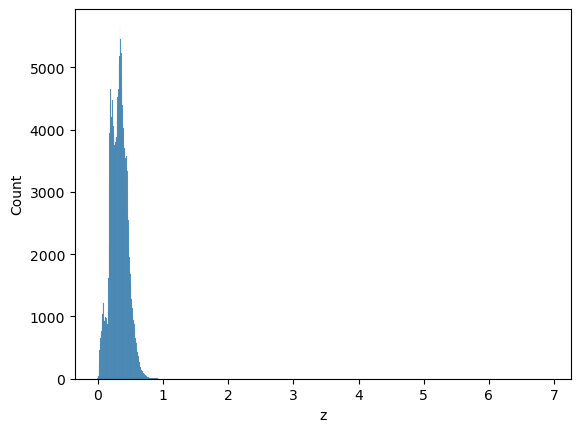

In [44]:
sns.histplot(TeddyCustom.z)

In [53]:
TeddyCustom.query("z>1")

,SDSSID,SDSSRa,SDSSDec,PS1ID,PS1AngSep,PS1Ra,PS1Dec,TMassID,TMassAngSep,TMassRa,...,zKronMagErr,yKronMagErr,j_m,h_m,k_m,j_err,h_err,k_err,z,ZErr
1231,1237648704587236323,206.618860,0.115951,108132066188419679,0.002025,206.618848,0.115984,<NA>,NaN,NaN,...,0.018901,0.048125,NaN,NaN,NaN,NaN,NaN,NaN,1.686932,0.000734
3236,1237648721230758728,180.111760,-0.103082,107871801117336752,0.000667,180.111776,-0.103075,<NA>,NaN,NaN,...,0.015179,0.031740,NaN,NaN,NaN,NaN,NaN,NaN,1.274839,0.000034
4372,1237648722314461376,202.740240,0.720701,108862027402855367,0.001638,202.740229,0.720738,<NA>,NaN,NaN,...,0.009623,0.016035,NaN,NaN,NaN,NaN,NaN,NaN,1.484491,0.000514
10361,1237651226246906390,260.581490,56.635286,175962605814623030,0.000504,260.581507,56.635278,1013542461,0.002349,260.581531,...,0.009702,0.014633,17.428,17.151,16.887,0.124,0.154,0.150,1.412565,0.000378
12857,1237651252565442937,148.315800,61.302682,181561483155953848,0.007796,148.315879,61.302559,<NA>,NaN,NaN,...,0.024003,0.039185,NaN,NaN,NaN,NaN,NaN,NaN,6.560494,0.001408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299545,1237679997697131102,340.294560,-2.207813,105353402945951043,0.001630,340.294602,-2.207763,<NA>,NaN,NaN,...,0.030363,0.094983,NaN,NaN,NaN,NaN,NaN,NaN,1.520873,0.328135
304250,1237680251096596660,27.405320,28.156862,141780274053098838,0.001990,27.405272,28.156893,<NA>,NaN,NaN,...,0.044469,0.063753,NaN,NaN,NaN,NaN,NaN,NaN,1.241523,3.395986
304723,1237680268278367409,334.098880,17.502782,129003340989503916,0.003436,334.098944,17.502814,<NA>,NaN,NaN,...,0.027688,0.048746,NaN,NaN,NaN,NaN,NaN,NaN,1.896334,0.000024
309427,1237680328414855800,345.773600,31.102273,145323457736113338,0.000338,345.773614,31.102289,839658132,0.003171,345.773589,...,0.012453,0.021705,17.726,17.554,16.901,0.181,0.226,0.124,1.704757,0.000281
